In [98]:
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
import math
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns



## Data cleaning 
In this chapter we check which of the datsets we have are usefull for our purpose

In [112]:
df_curatedSol = pd.read_csv('../Data/CuratedSol.csv')
df_biogen = pd.read_csv('../Data/Biogen.csv')
df_bioavailability = pd.read_csv('../Data/Bioavailibility.csv')
df_ESOL = pd.read_csv('../Data/ESOL.csv')
df_Water_Octanol = pd.read_csv('../Data/Water_Octanol.csv')
df_Bold_brain_barrier = pd.read_csv('../Data/Blood-brain_barrier_binary.csv')
df_Kinetic_solubility = pd.read_csv('../Data/KineticAqueousSolubility.csv')
df_permeability = pd.read_csv('../Data/Permeability_ph7_4.csv')
df_PAMPA_ph7_4 = pd.read_csv('../Data/PAMPA_ph_7_4.csv')
#df_Pharma_drugs = pd.read_csv('../Data/Pharmaceutical Drugs_Dataset.csv')
df_oral_adsorption = pd.read_csv('../Data/Oral adsorbtion.csv')
df_binary_bioavailibility = pd.read_csv('../Data/Binary_Bioavailibility.csv')
df_OCHEM = pd.read_csv('../Data/OCHEM_Sol.csv')
df_WEI_Bioav = pd.read_csv('../Data/HOB_Bioavailibility_Wei_2022.csv')
df_merged_Bioavailibility = pd.read_csv('../Data/Merged_Bioavailibility.csv')
df_merged_Solubility = pd.read_csv('../Data/Merged_solubility.csv')

In [188]:
#df_curatedSol.head()
#df_bioavailability.head() #995
#df_biogen.head() #3521
#df_ESOL.head() #1128
#df_Water_Octanol.head()#4200
#df_Bold_brain_barrier.head() #2050
#df_Kinetic_solubility.head() #2532
#df_permeability.head() #2530
#df_PAMPA_ph7_4.head() #2532
df_oral_adsorption.head()
#df_binary_bioavailibility.head(20)
#df_water_sol_Ochem.head(100) 


,SMILES,EXTERNALID,N,NAME,ARTICLEID,PUBMEDID,PAGE,TABLE,Oral absorption,UNIT {Oral absorption},...,UNIT {Oral absorption}.1,Species,AssayID,UNIT {AssayID},Molecule ChEMBL ID,UNIT {Molecule ChEMBL ID},Document ChEMBL ID,UNIT {Document ChEMBL ID},Clinical phase,UNIT {Clinical phase}
0,C1(=C(C=C(NC(CCC)=O)C=C1)C(C)=O)OCC(CNC(C)C)O,-,2,Acebutolol,A166,9874698,30,1,90.0,%,...,%,NaN,NaN,-,NaN,-,NaN,-,NaN,-
1,C1(=CC=C(O)C=C1)NC(C)=O,-,3,Acetaminophen,A166,9874698,30,1,80.0,%,...,%,NaN,NaN,-,NaN,-,NaN,-,NaN,-
2,C1(=C(C=CC=C1)OC(C)=O)C(=O)O,-,4,Acetylsalicylic acid,A166,9874698,30,1,100.0,%,...,%,NaN,NaN,-,NaN,-,NaN,-,NaN,-
3,C(C1=NC(=CC=C1)C=CC(O)=O)(C2=CC=C(C)C=C2)=CCN3...,-,5,acrivastine,A166,9874698,30,1,88.0,%,...,%,NaN,NaN,-,NaN,-,NaN,-,NaN,-
4,O(CN1C=2NC(=NC(=O)C2N=C1)N)CCO,-,6,Acyclovir,A166,9874698,30,1,16.0,%,...,%,NaN,NaN,-,NaN,-,NaN,-,NaN,-


## Functions for data preperation

In [29]:
def canonicalize(Dataframe: pd.DataFrame, column_name: str):
    
    """Canonicalizes the SMILES from Dataframe. A column called 'SMILES' is requiered

    Args: 
        Dataframe with 'SMILES' column contaning smiles. 
    """
    
    Dataframe[column_name] = Dataframe[column_name].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x))) #canonicalize smiles from a Dataframe                                          
    

In [30]:
def add_Lipinski_descriptors(Dataframe: pd.DataFrame, column_name: str):

   """This function takes a dataframe and adds the Lipinski descriptors 
      (Molecular weight in Dalton, Number of H-acceptors and donors and the 
      logP value) to it. It also adds a column witch says if the molecule follows 
      the Lipinski's rule of five. (1= yes, 0= no)
    
   Args: 
      Pandas Dataframe with a column witch contains the SMILES strings.
   """
   Dataframe['MolW(Da)'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.MolWt(Chem.MolFromSmiles(x)))

   Dataframe['NumHAcceptors'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))

   Dataframe['NumHDonors'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.NumHDonors(Chem.MolFromSmiles(x)))

   Dataframe['LogP'] = Dataframe[column_name].apply(lambda x: Chem.Descriptors.MolLogP(Chem.MolFromSmiles(x)))

   Dataframe['Lipinski_rule'] = Dataframe.apply(lambda x: 1 if x['MolW(Da)'] <= 500 and x['NumHAcceptors'] <= 10 and x['NumHDonors'] <= 5 and x['LogP'] <= 5 else 0, axis=1)

In [17]:
def convert_solubility(Dataframe: pd.DataFrame, column_solubility: str, column_Mw: str):
    """
    Converts the solubility values from a DataFrame from log(ug/mL) to log(mol/L).
    
    Args:
        dataframe (pd.DataFrame): DataFrame with the solubility values.
        column_solubility (str): Column name containing solubility values in log(ug/L).
        column_Mw (str): Column name containing molecular weight (Mw) values in g/mol.
    
    Returns:
        pd.DataFrame: DataFrame with an additional column for solubility in log(mol/L).
    """
    # Define a function to apply to each row
    def convert_log_solubility(row):
        log_ug_per_L = row[column_solubility]
        molar_mass = row[column_Mw]
        # Perform the conversion
        log_mol_per_L = log_ug_per_L - 3 - math.log10(molar_mass)
        return log_mol_per_L
    
    # Apply the conversion function to each row and create a new column
    Dataframe['Solubility_log(mol/L)'] = Dataframe.apply(convert_log_solubility, axis=1)
    
    return Dataframe

In [28]:
def calc_Solubility_molL(Dataframe: pd.DataFrame, coulmn_name: str):
    
    """Calculates the solubility in mol/L from a Dataframe with a column containing solubility in log(mol/L).

    Args: 
        Dataframe with column containing solubility values in log(mol/L).
    """
    
    Dataframe['Solubility(mol/L)'] = Dataframe[coulmn_name].apply(lambda x: 10**x)

    return Dataframe

In [19]:
def drop_analysis(Dataframe: pd.DataFrame):

    """Drops duplicates and missing SOL data from a Dataframe.

    Args:
        Dataframe with a column containing SMILES strings and a column containing solubility values.
    """
    
    len = Dataframe.shape[0]
    data = Dataframe.drop_duplicates(subset="SMILES", keep='first')
    data2 = Dataframe.dropna(subset=['Solubility_log(mol/L)'])
    data3 = Dataframe.dropna(subset=['Solubility(mol/L)']).drop_duplicates(subset="SMILES", keep='first')
    print(f"dropped (missing SOL data): {len - data2.shape[0]}\ndropped (duplicates): {len - data.shape[0]}\ndropped (total): {len - data3.shape[0]}")

    return data3

# Preparing data for combining
Here we canonicalize the SMILES strings, add the Lipinski descriptors and add the Solubility in mol/L to the Dataframe. The Water Solubility in all compounds is given as log(mol/L).

In [20]:
canonicalize(df_OCHEM, 'SMILES')
add_Lipinski_descriptors(df_OCHEM, 'SMILES')
calc_Solubility_molL(df_OCHEM, 'Solubility_log(mol/L)')
#saving as csv
df_OCHEM.to_csv('../Data/OCHEM_Sol.csv', index=False)
df_OCHEM.shape #5000

(5000, 13)

In [170]:
canonicalize(df_ESOL, 'SMILES')
add_Lipinski_descriptors(df_ESOL, 'SMILES')
calc_Solubility_molL(df_ESOL, 'Solubility_log(mol/L)')
df_ESOL.to_csv('../Data/ESOL.csv', index=False)
df_ESOL.shape #1128

(1128, 16)

In [172]:
canonicalize(df_biogen, 'SMILES')
add_Lipinski_descriptors(df_biogen, 'SMILES')
calc_Solubility_molL(df_biogen, 'Solubility_log(mol/L)')
df_biogen.to_csv('../Data/Biogen.csv', index=False)
df_biogen.shape #3521

(3521, 17)

In [173]:
canonicalize(df_curatedSol, 'SMILES')
add_Lipinski_descriptors(df_curatedSol, 'SMILES')
calc_Solubility_molL(df_curatedSol, 'Solubility_log(mol/L)')
df_curatedSol.to_csv('../Data/CuratedSol.csv', index=False)
df_curatedSol.shape #9982

[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not removing hydrogen atom without neighbors
[16:59:47] WARNING: not r

(9982, 30)

## Combining data
Combing all the solubility data (ESOL, curated, Biogen, OCHEM) to one big dataframe which contains SMILES, Solubility in log(mol/L), Mw and Lipinski descriptors

In [183]:
df_merged_1 = pd.merge(df_curatedSol, df_biogen, on=['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])
df_merged_1_cleand = drop_analysis(df_merged_1)

dropped (missing SOL data): 1348
dropped (duplicates): 23
dropped (total): 1356


Here we saw: the biogen datasets has a lot of missing water solubility data.

In [184]:
df_merged_2 = pd.merge(df_merged_1_cleand, df_ESOL, on=['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])
df_merged_2_cleand = drop_analysis(df_merged_2)

dropped (missing SOL data): 0
dropped (duplicates): 1035
dropped (total): 1035


Here we saw: the ESOL data contained some duplicates

In [185]:
df_merged_3 = pd.merge(df_merged_2_cleand, df_OCHEM, on=['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', 'Solubility_log(mol/L)', 'Solubility(mol/L)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])
df_merged_3_cleand = drop_analysis(df_merged_3)

dropped (missing SOL data): 0
dropped (duplicates): 4173
dropped (total): 4173


Here we saw: most of the OCHEM Smiles were already in the other datasets

In [186]:
df_merged_3_cleand.to_csv('../Data/Merged_solubility.csv', index=False)

## Distribution of the Solubility data

In [113]:
df_merged_Solubility.head()

,SMILES,Solubility_log(mol/L),Solubility(mol/L),MolW(Da),NumHAcceptors,NumHDonors,LogP,Lipinski_rule
0,B#N,-6.394784,4.029171e-07,24.819,1,0,-0.36572,1
1,B12B3B4B1C234,-4.742403,1.809660e-05,55.259,0,0,-1.30840,1
2,Br/C=C/Br,-1.741500,1.813427e-02,185.846,0,0,2.24740,1
3,Br/C=C\Br,-1.319500,4.791815e-02,185.846,0,0,2.24740,1
4,BrC(Br)(Br)Br,-3.140400,7.237690e-04,331.627,0,0,3.17730,1


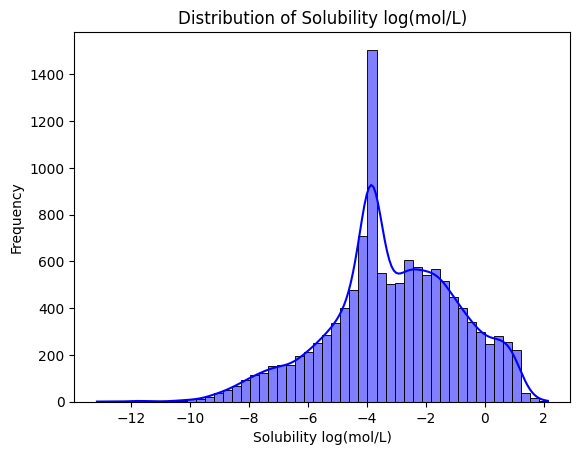

In [120]:
sns.histplot(data=df_merged_Solubility, x='Solubility_log(mol/L)', kde=True, bins=50, color='blue')
plt.title('Distribution of Solubility log(mol/L)')
plt.xlabel('Solubility log(mol/L)')
plt.ylabel('Frequency')
plt.show()

## Bioavailibility Data

In [8]:
excel_file_path = '/Users/matthiasgalka/git/AI-for-Chemistry/Data/hob_data_set.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file_path)

# Specify the path to the output CSV file
csv_file_path = '../Data/hob_data_set.csv'

# Write the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

In [23]:
mask = ~df_WEI_Bioav['value'].str.contains('[><\[\]=~≈]', regex=True)

# Filter the DataFrame using the mask
df_cleaned = df_WEI_Bioav[mask]

In [47]:
df_cleaned.head()

,Name,smile,value,label_cutoff_50%,our model predition_50%,label_cutoff_20%,our model predition_20%
0,sulfadiazine,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,90,1,1,1.0,1.0
1,clofarabine,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,50,1,1,1.0,1.0
2,sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,99,1,1,1.0,1.0
3,tolazoline,c1ccc(CC2=NCCN2)cc1,90,1,1,1.0,1.0
4,cotinine,CN1C(=O)CCC1c1cccnc1,97,1,1,1.0,1.0


In [85]:
def calc_logK(Dataframe: pd.DataFrame, column_name: str):
    """
    Calculates the logK from a DataFrame with a column containing K values.

    Args:
        Dataframe with column containing %F values.
    """
    Dataframe['logK(%F)'] = Dataframe[column_name].apply(lambda x: math.log10(x/(100-x)))

    return Dataframe

In [50]:
df_cleaned.shape

(1051, 7)

In [48]:
df = df_bioavailability.rename(columns={'Updated SMILES': 'SMILES'})
canonicalize(df, 'SMILES')
add_Lipinski_descriptors(df, 'SMILES')
df.to_csv('../Data/Bioavailibility.csv', index=False)

In [51]:
df1 = df_cleaned.rename(columns={'smile': 'SMILES', 'value': '%F'})
df1['%F'] = df1['%F'].astype(float)
#calc_logK(df1, '%F')
canonicalize(df1, 'SMILES')
add_Lipinski_descriptors(df1, 'SMILES')
df1.to_csv('../Data/HOB_Bioavailibility_Wei_2022.csv', index=False)


In [72]:
df_WEI_Bioav['%F'] = df_WEI_Bioav['%F'].replace({100.0: 99.99, 0.0: 0.01})

df_WEI_Bioav.head(10)
#df_bioavailability.head()


,Name,SMILES,%F,label_cutoff_50%,our model predition_50%,label_cutoff_20%,our model predition_20%,MolW(Da),NumHAcceptors,NumHDonors,LogP,Lipinski_rule
0,sulfadiazine,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,90.00,1,1,1.0,1.0,250.283,5,2,0.85960,1
1,clofarabine,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,50.00,1,1,1.0,1.0,303.681,8,3,-0.34940,1
2,sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,99.00,1,1,1.0,1.0,253.283,5,2,1.36602,1
3,tolazoline,c1ccc(CC2=NCCN2)cc1,90.00,1,1,1.0,1.0,160.220,2,1,1.23080,1
4,cotinine,CN1C(=O)CCC1c1cccnc1,97.00,1,1,1.0,1.0,176.219,2,0,1.37490,1
5,methylaminorex,CC1NC(=N)OC1c1ccccc1,62.00,1,1,1.0,1.0,176.219,2,2,1.67077,1
6,ritipenem,CC(O)C1C(=O)N2C(C(=O)O)=C(COC(=N)O)SC12,37.00,0,0,1.0,1.0,288.281,6,4,-0.29593,1
7,didanosine,OCC1CCC(n2cnc3c(O)ncnc32)O1,38.00,0,0,1.0,1.0,236.231,7,2,0.20180,1
8,tazobactam,CC1(Cn2ccnn2)C(C(=O)O)N2C(=O)CC2S1(=O)=O,0.01,0,0,0.0,0.0,300.296,7,1,-1.52320,1
9,phenylbutyrate,O=C(O)CCCc1ccccc1,78.00,1,1,1.0,1.0,164.204,1,1,2.09390,1


In [84]:
df_log = calc_logK(df_WEI_Bioav, '%F')

In [89]:
df_log.to_csv('../Data/HOB_Bioavailibility_Wei_2022.csv', index=False)

/var/folders/56/k5y5cj453pvcsblxlzlzn0340000gn/T/ipykernel_38928/3758048854.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


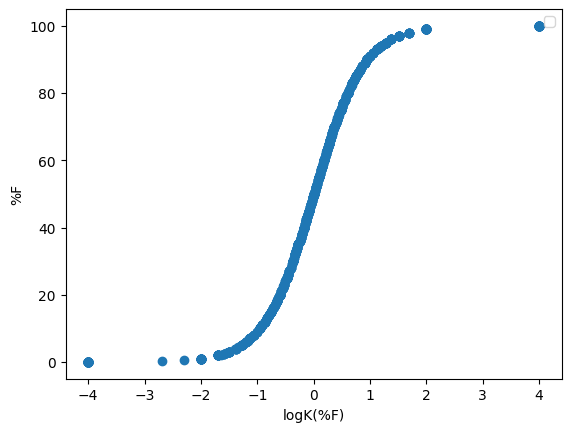

In [88]:
fig, ax = plt.subplots()
#ax.scatter(df_polarity["Solvent"], df_polarity["Elutropic_series"], label="Elutropic series")
ax.scatter(df_log["logK(%F)"], df_log["%F"])
#ax.scatter(df_polarity["Solvent"], df_polarity["Dielectric_constant"], label="Dielectric constant")
#ax.scatter(df_polarity["Solvent"], df_polarity["Dipole_moment"], label="Dipole moment")
#ax.scatter(df_polarity["Solvent"], df_polarity["ET30N"], label="ET30N")

ax.set_xlabel('logK(%F)')
ax.set_ylabel("%F")
ax.legend()

## Combining Bioavailibility data

In [91]:
df_WEI_Bioav


,Name,SMILES,%F,label_cutoff_50%,our model predition_50%,label_cutoff_20%,our model predition_20%,MolW(Da),NumHAcceptors,NumHDonors,LogP,Lipinski_rule,logK(%F)
0,sulfadiazine,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,90.0,1,1,1.0,1.0,250.283,5,2,0.85960,1,0.954243
1,clofarabine,Nc1nc(Cl)nc2c1ncn2C1OC(CO)C(O)C1F,50.0,1,1,1.0,1.0,303.681,8,3,-0.34940,1,0.000000
2,sulfamethoxazole,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,99.0,1,1,1.0,1.0,253.283,5,2,1.36602,1,1.995635
3,tolazoline,c1ccc(CC2=NCCN2)cc1,90.0,1,1,1.0,1.0,160.220,2,1,1.23080,1,0.954243
4,cotinine,CN1C(=O)CCC1c1cccnc1,97.0,1,1,1.0,1.0,176.219,2,0,1.37490,1,1.509650
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,clonidine,Clc1cccc(Cl)c1NC1=NCCN1,95.0,1,1,1.0,1.0,230.098,3,2,2.36450,1,1.278754
1047,guanfacine,N=C(N)N=C(O)Cc1c(Cl)cccc1Cl,81.0,1,1,1.0,1.0,246.097,1,3,2.38587,1,0.629731
1048,diloxanide,CN(C(=O)C(Cl)Cl)c1ccc(O)cc1,90.0,1,1,1.0,1.0,234.082,2,1,2.15870,1,0.954243
1049,clodronate,O=P([O-])([O-])C(Cl)(Cl)P(=O)(O)O,1.0,0,0,0.0,0.0,242.875,4,2,-0.83330,1,-1.995635


In [93]:
df_merged_Bioavailibility = pd.merge(df_bioavailability, df_WEI_Bioav, on=['SMILES', '%F', 'logK(%F)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'], how='outer').filter(['SMILES', '%F', 'logK(%F)', 'MolW(Da)', 'NumHAcceptors', 'NumHDonors', 'LogP', 'Lipinski_rule'])


In [94]:
len = df_merged_Bioavailibility.shape[0]
df_after_drop = df_merged_Bioavailibility.drop_duplicates(subset="SMILES", keep='first')
print(f"dropped (duplicates): {len - df_after_drop.shape[0]}")


dropped (duplicates): 442


In [105]:
df_after_drop.to_csv('../Data/Merged_Bioavailibility.csv', index=False)

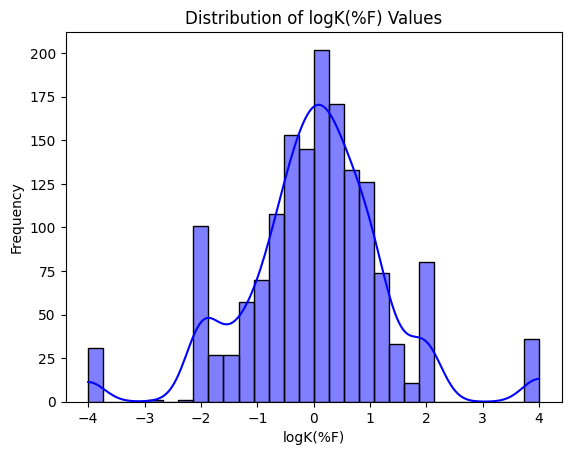

In [119]:
sns.histplot(data=df_merged_Bioavailibility, x='logK(%F)', kde=True, bins=30, color='blue')
plt.title('Distribution of logK(%F) Values')
plt.xlabel('logK(%F)')
plt.ylabel('Frequency')
plt.show()